# ***START***

# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import cv2
import random

#Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Read Dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DatasetForColab/EthnicLanguage/BdEthnicLanguages.csv')

In [4]:
df.head()

,Converted Text,Language
0,𑄃𑄬𑄇𑄴 𑄎𑄧𑄚𑄴 𑄝𑄪𑄢𑄦 𑄟𑄚𑄪 𑄝𑄎𑄢𑄬 𑄃𑄇𑄴𑄑 𑄥𑄧𑄠𑄴𑄥𑄴𑄛𑄨𑄥𑄴 𑄘𑄪𑄘𑄪𑄇𑄮...,Chakma
1,𑄝𑄉𑄚𑄴 𑄇𑄮𑄢𑄨𑄠 𑄛𑄢𑄴𑄝𑄮𑄑𑄬𑄢𑄴 𑄣𑄉𑄮𑄑𑄴 𑄘𑄮𑄢𑄨 𑄘𑄮𑄢𑄨 𑄃𑄇𑄴𑄑 𑄌𑄨𑄑𑄨...,Chakma
2,𑄝𑄨𑄣𑄃𑄨 𑄚𑄮𑄘𑄨𑄢𑄴 𑄘𑄢𑄬 𑄃𑄇𑄴𑄑 𑄉𑄪𑄛𑄴𑄑𑄮 𑄇𑄮𑄑𑄦 𑄥𑄪𑄚𑄴𑄘𑄮𑄢 𑄝𑄝𑄬 ...,Chakma
3,𑄘𑄇𑄴𑄑𑄢𑄴 𑄝𑄎𑄢𑄬 𑄅𑄖𑄴𑄥𑄦𑄬 𑄃𑄇𑄴𑄑 𑄉𑄌𑄮𑄢𑄴 𑄝𑄦𑄨𑄣𑄮।,Chakma
4,𑄝𑄉𑄚𑄴 𑄇𑄮𑄢𑄨𑄠 𑄛𑄢𑄴𑄇𑄣𑄬 𑄘𑄮𑄢𑄨 𑄘𑄮𑄢𑄨 𑄃𑄇𑄴𑄑 𑄉𑄃𑄚𑄴 𑄃𑄁𑄇𑄨𑄣𑄮।,Chakma


In [5]:
df.shape

(4713, 2)

In [6]:
df['Language'].value_counts().reset_index()

,Language,count
0,Chakma,1057
1,Marma,966
2,Rakhine,906
3,Santali,869
4,Garo,822
5,Tripura,93


In [7]:
df = df[df['Language'] != 'Tripura']

In [8]:
df['Language'].value_counts().reset_index()

,Language,count
0,Chakma,1057
1,Marma,966
2,Rakhine,906
3,Santali,869
4,Garo,822


In [9]:
max_count = df['Language'].value_counts().max()
max_count

1057

# Data Augmentation

In [10]:
df.columns

Index(['Converted Text', 'Language'], dtype='object')

In [11]:
def random_swap(words, n=1):
    words = words.copy()
    if len(words) < 2:
        return words
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return words

def random_deletion(words, p=0.2):
    if len(words) == 1:
        return words
    return [w for w in words if random.random() > p] or words  # fallback if all removed

def random_insertion(words, n=1):
    for _ in range(n):
        idx = random.randint(0, len(words)-1)
        words.insert(random.randint(0, len(words)), words[idx])
    return words

def augment_sentence(sentence):
    words = sentence.split()
    if len(words) < 2:
        return sentence

    method = random.choice(['swap', 'delete', 'insert'])
    if method == 'swap':
        aug_words = random_swap(words)
    elif method == 'delete':
        aug_words = random_deletion(words)
    elif method == 'insert':
        aug_words = random_insertion(words)
    else:
        aug_words = words

    return ' '.join(aug_words)

# Step 5: Perform augmentation + oversampling
augmented_data = []

for lang, group in df.groupby('Language'):
    original_texts = group['Converted Text'].tolist()  # updated column name
    needed = max_count - len(group)

    new_samples = []
    i = 0
    while len(new_samples) < needed:
        text = original_texts[i % len(original_texts)]
        aug_text = augment_sentence(text)
        new_samples.append({'Converted Text': aug_text, 'Language': lang})
        i += 1

    lang_df = pd.concat([group, pd.DataFrame(new_samples)], ignore_index=True)
    augmented_data.append(lang_df)

# Step 6: Combine and shuffle
balanced_df = pd.concat(augmented_data, ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Save result
balanced_df.to_csv("balanced_tribal_augmented_dataset.csv", index=False)

print("✅ Dataset balanced and saved! Total samples:", len(balanced_df))
print(balanced_df['Language'].value_counts())

✅ Dataset balanced and saved! Total samples: 5285
Language
Marma       1057
Chakma      1057
Santali     1057
Garo        1057
Rakhine     1057
Name: count, dtype: int64


#Model Trianing

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters
MAX_LEN = 300  # max number of characters per sample
CHAR_VOCAB = sorted(list(set(''.join(balanced_df['Converted Text']))))
char2idx = {c: i+1 for i, c in enumerate(CHAR_VOCAB)}  # reserve 0 for padding

# Encode text as character indices
def encode_text(text):
    return [char2idx.get(c, 0) for c in text[:MAX_LEN]]

X = balanced_df['Converted Text'].apply(encode_text).tolist()
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

# Encode labels
le = LabelEncoder()
y = le.fit_transform(balanced_df['Language'])
y = to_categorical(y)

print("✅ Text and labels encoded!")


✅ Text and labels encoded!


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential([
    Embedding(input_dim=210, output_dim=64, input_shape=(300,) ),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # assuming 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 64)        │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,109 (246.52 KB)

 Trainable params: 63,109 (246.52 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.222, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5090 - loss: 1.3208 - val_accuracy: 0.8892 - val_loss: 0.2942
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8887 - loss: 0.2539 - val_accuracy: 0.9176 - val_loss: 0.2049
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.9216 - loss: 0.1764 - val_accuracy: 0.9261 - val_loss: 0.1746
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9432 - loss: 0.1375 - val_accuracy: 0.9337 - val_loss: 0.1736
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9491 - loss: 0.1192 - val_accuracy: 0.9309 - val_loss: 0.1616
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9537 - loss: 0.1045 - val_accuracy: 0.9318 - val_loss: 0.1642
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.9657 - loss: 0.0868 - val_accuracy: 0.9337 - val_loss: 0.1614
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9705 - loss: 0.0780 - val_accuracy:

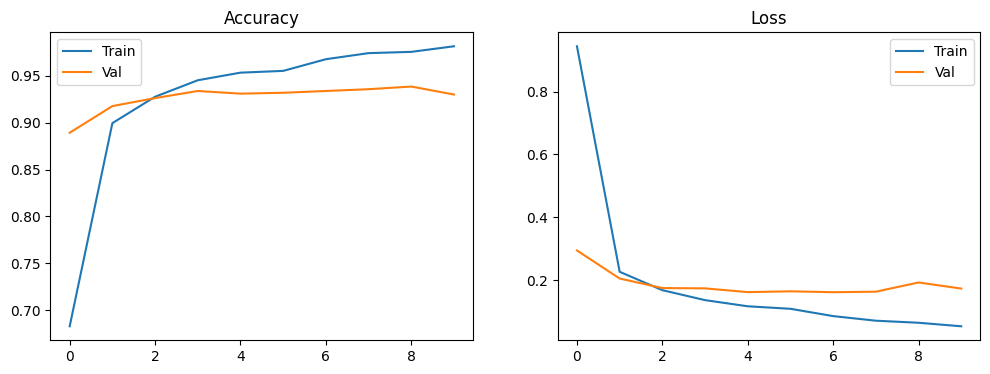

In [15]:
import matplotlib.pyplot as plt

# Accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()


In [16]:
print("Max token index:", X_train.max())


Max token index: 202


# Model Testing


In [17]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=64)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9406 - loss: 0.1563
Validation Loss: 0.1583
Validation Accuracy: 0.9376


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Prediction Accuracy: 0.9376181474480151


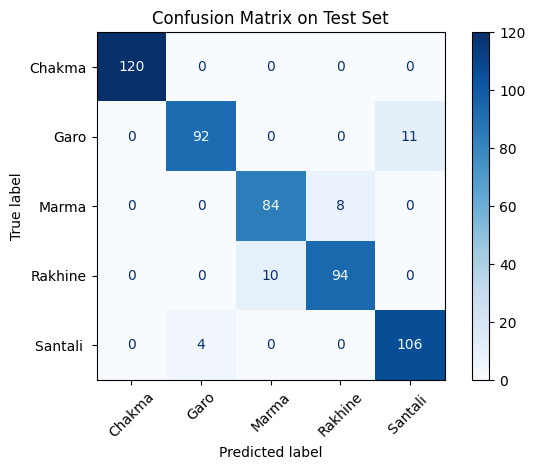

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       0.96      0.89      0.92       103
           2       0.89      0.91      0.90        92
           3       0.92      0.90      0.91       104
           4       0.91      0.96      0.93       110

    accuracy                           0.94       529
   macro avg       0.94      0.93      0.93       529
weighted avg       0.94      0.94      0.94       529



In [27]:
y_pred = model.predict(X_test)

y_test_labels = np.argmax(y_test, axis=1)

y_pred_classes = np.argmax(y_pred, axis=1)

class_names = le.classes_

accuracy = accuracy_score(y_test_labels, y_pred_classes)
print('Prediction Accuracy:', accuracy)

cm = confusion_matrix(y_test_labels, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

print('Classification Report:')
print(classification_report(y_test_labels, y_pred_classes))

# ***END***